<a href="https://colab.research.google.com/github/rawar/tensorflow-notebooks/blob/master/stock_price_prediction_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict stock prices  with Long short-term memory (LSTM)

This simple example will show you how LSTM models predict time series data. Stock market data is a great choice for this because it's quite regular and widely available via the Internet. 

## Install requirements
We install Tensorflow 2.0 with GPU support first

In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0

In [2]:
!pip install pandas-datareader

In [3]:
!apt install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [4]:
!pip install pydot pydot-ng

## Introduction

LSTMs are very powerful in sequence prediction problems. They can store past information.

## Loading the dataset
I use pandas-datareader to get the historical stock prices from Yahoo! finance. For this example, I get only the historical data till the end of *training_end_data*.  

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data

In [0]:
tickers = 'AAPL'

start_date = '1980-12-01'
end_date = '2018-12-31'

stock_data = data.get_data_yahoo(tickers, start_date, end_date)

In [7]:
stock_data.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1980-12-12,0.515625,0.513393,0.513393,0.513393,117258400.0,0.023007
1980-12-15,0.488839,0.486607,0.488839,0.486607,43971200.0,0.021807
1980-12-16,0.453125,0.450893,0.453125,0.450893,26432000.0,0.020206
1980-12-17,0.464286,0.462054,0.462054,0.462054,21610400.0,0.020706
1980-12-18,0.477679,0.475446,0.475446,0.475446,18362400.0,0.021307
1980-12-19,0.506696,0.504464,0.504464,0.504464,12157600.0,0.022607
1980-12-22,0.531250,0.529018,0.529018,0.529018,9340800.0,0.023707
1980-12-23,0.553571,0.551339,0.551339,0.551339,11737600.0,0.024708
1980-12-24,0.582589,0.580357,0.580357,0.580357,12000800.0,0.026008


In [8]:
stock_data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,9594.000000,9594.000000,9594.000000,9594.000000,9.594000e+03,9594.000000
mean,26.549240,26.026566,26.297032,26.292735,8.758682e+07,22.587725
std,47.280499,46.462657,46.880676,46.878276,8.676287e+07,44.664584
min,0.198661,0.196429,0.198661,0.196429,3.472000e+05,0.008803
25%,1.071429,1.031295,1.049464,1.051429,3.407435e+07,0.148196
50%,1.696429,1.633929,1.664286,1.665179,5.944890e+07,0.879176
75%,26.317500,25.404285,25.910000,25.841429,1.091926e+08,17.231145
max,233.470001,229.779999,230.779999,232.070007,1.855410e+09,230.275482


In [9]:
stock_data_len = stock_data['Close'].count()
print(stock_data_len)

9594


I'm only interested in *close* prices

In [10]:
close_prices = stock_data.iloc[:, 1:2].values
print(close_prices)

[[  0.51339287]
 [  0.48660713]
 [  0.45089287]
 ...
 [150.07000732]
 [154.55000305]
 [156.47999573]]


Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices

In [11]:
all_bussinessdays = pd.date_range(start=start_date, end=end_date, freq='B')
print(all_bussinessdays)

DatetimeIndex(['1980-12-01', '1980-12-02', '1980-12-03', '1980-12-04',
               '1980-12-05', '1980-12-08', '1980-12-09', '1980-12-10',
               '1980-12-11', '1980-12-12',
               ...
               '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21',
               '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27',
               '2018-12-28', '2018-12-31'],
              dtype='datetime64[ns]', length=9936, freq='B')


In [0]:
close_prices = stock_data.reindex(all_bussinessdays)
close_prices = stock_data.fillna(method='ffill')

In [13]:
close_prices.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1980-12-12,0.515625,0.513393,0.513393,0.513393,117258400.0,0.023007
1980-12-15,0.488839,0.486607,0.488839,0.486607,43971200.0,0.021807
1980-12-16,0.453125,0.450893,0.453125,0.450893,26432000.0,0.020206
1980-12-17,0.464286,0.462054,0.462054,0.462054,21610400.0,0.020706
1980-12-18,0.477679,0.475446,0.475446,0.475446,18362400.0,0.021307
1980-12-19,0.506696,0.504464,0.504464,0.504464,12157600.0,0.022607
1980-12-22,0.531250,0.529018,0.529018,0.529018,9340800.0,0.023707
1980-12-23,0.553571,0.551339,0.551339,0.551339,11737600.0,0.024708
1980-12-24,0.582589,0.580357,0.580357,0.580357,12000800.0,0.026008


The dataset is now complete and free of missing values. Let's have a look to the data frame summary:

## Feature scaling

In [0]:
training_set = close_prices.iloc[:, 1:2].values

In [15]:
print(training_set)

[[  0.51339287]
 [  0.48660713]
 [  0.45089287]
 ...
 [150.07000732]
 [154.55000305]
 [156.47999573]]


In [16]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled.shape)

(9594, 1)


LSTMs expect the data in a specific format, usually a 3D tensor. I start by creating data with 60 days and converting it into an array using NumPy. Next, I convert the data into a 3D dimension array with feature_set samples, 60 days and one feature at each step.

In [0]:
features = []
labels = []
for i in range(60, stock_data_len):
    features.append(training_set_scaled[i-60:i, 0])
    labels.append(training_set_scaled[i, 0])

features = np.array(features)
labels = np.array(labels)

features = np.reshape(features, (features.shape[0], features.shape[1], 1))

In [18]:
print(labels)

[0.00082642 0.00089448 0.00087503 ... 0.6528062  0.67231978 0.68072627]


In [19]:
print(features)

[[[1.38060532e-03]
  [1.26393438e-03]
  [1.10837330e-03]
  ...
  [1.13754103e-03]
  [9.81979819e-04]
  [8.94476613e-04]]

 [[1.26393438e-03]
  [1.10837330e-03]
  [1.15698610e-03]
  ...
  [9.81979819e-04]
  [8.94476613e-04]
  [8.26418607e-04]]

 [[1.10837330e-03]
  [1.15698610e-03]
  [1.21532157e-03]
  ...
  [8.94476613e-04]
  [8.26418607e-04]
  [8.94476613e-04]]

 ...

 [[9.85059938e-01]
  [9.86279533e-01]
  [1.00000000e+00]
  ...
  [6.50889679e-01]
  [6.37648276e-01]
  [6.38214540e-01]]

 [[9.86279533e-01]
  [1.00000000e+00]
  [9.86715064e-01]
  ...
  [6.37648276e-01]
  [6.38214540e-01]
  [6.52806203e-01]]

 [[1.00000000e+00]
  [9.86715064e-01]
  [9.59927459e-01]
  ...
  [6.38214540e-01]
  [6.52806203e-01]
  [6.72319776e-01]]]


Feature tensor with three dimension: features[0] contains the ..., features[1] contains the last 60 days of values and features [2] contains the  ...

In [20]:
print(features.shape)

(9534, 60, 1)


## Create the LSTM network
Let's create a sequenced LSTM network with 50 units. Also the net includes some dropout layers with 0.2 which means that 20% of the neurons will be dropped.

In [0]:
import tensorflow as tf

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (features.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1)
])

W0414 15:18:15.979501 139980101556096 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f4f34285860>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0414 15:18:16.001110 139980101556096 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f4f34285ef0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0414 15:18:16.006853 139980101556096 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f4f342a6748>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0414 15:18:16.013553 139980101556096 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f4f342a6e48>: Note that this layer is not optimized for performance. Please use tf.keras.laye

In [23]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm (UnifiedLSTM)   (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
unified_lstm_2 (UnifiedLSTM) (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
unified_lstm_3 (UnifiedLSTM) (None, 50)                2

In [0]:
#tf.keras.utils.plot_model(model, to_file='my_model.png')


In [0]:
# Run tensorboard with the logdir
#import os
#LOG_BASE_DIR = './log'
#os.makedirs(LOG_BASE_DIR, exist_ok=True)

In [0]:
#!ls -l log

## Load the Colab TensorBoard extention and start TensorBoard inline

In [0]:
#%load_ext tensorboard.notebook
#%tensorboard --logdir {LOG_BASE_DIR}

## Define a TensorBoard callback

In [0]:
#import datetime
#logdir = os.path.join(LOG_BASE_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [0]:
#from tensorflow.keras.callbacks import TensorBoard

#tbCallBack = TensorBoard(logdir,histogram_freq=1)

The model will be compiled and optimize by the adam optimizer and set the loss function as mean_squarred_error

In [0]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [0]:
#import os
#print(os.environ)

In [0]:
#tf.test.gpu_device_name()

In [0]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [33]:
from time import time
start = time()
history = model.fit(features, labels, epochs = 20, batch_size = 32, verbose = 1)
end = time()

Epoch 1/20
9534/9534 [==============================] - 19s 2ms/sample - loss: 0.0017
Epoch 2/20
9534/9534 [==============================] - 17s 2ms/sample - loss: 8.3861e-04
Epoch 3/20
9534/9534 [==============================] - 17s 2ms/sample - loss: 8.4889e-04
Epoch 4/20
9534/9534 [==============================] - 17s 2ms/sample - loss: 6.7823e-04
Epoch 5/20
9534/9534 [==============================] - 17s 2ms/sample - loss: 6.0230e-04
Epoch 6/20
9534/9534 [==============================] - 17s 2ms/sample - loss: 5.9530e-04
Epoch 7/20
9534/9534 [==============================] - 17s 2ms/sample - loss: 5.6053e-04
Epoch 8/20
9534/9534 [==============================] - 18s 2ms/sample - loss: 5.6923e-04
Epoch 9/20
9534/9534 [==============================] - 17s 2ms/sample - loss: 4.9843e-04
Epoch 10/20
9534/9534 [==============================] - 17s 2ms/sample - loss: 5.7040e-04
Epoch 11/20
9534/9534 [==============================] - 17s 2ms/sample - loss: 4.5142e-04
Epoch 12/20


In [34]:
print('Total training time {} seconds'.format(end - start))

Total training time 349.84911346435547 seconds


In [38]:
#  [samples, days, features]
print(features.shape)

(9534, 60, 1)


In [0]:
testing_start_date = '2019-01-01'
testing_end_date = '2019-04-10'

test_stock_data = data.get_data_yahoo(tickers, testing_start_date, testing_end_date)

In [49]:
test_stock_data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-04-04,196.369995,193.139999,194.789993,195.690002,19114300.0,195.690002
2019-04-05,197.100006,195.929993,196.449997,197.000000,18526600.0,197.000000
2019-04-08,200.229996,196.339996,196.419998,200.100006,25881700.0,200.100006
2019-04-09,202.850006,199.229996,200.320007,199.500000,35768200.0,199.500000
2019-04-10,200.740005,198.179993,198.679993,200.619995,21695300.0,200.619995


In [0]:
test_stock_data_processed = test_stock_data.iloc[:, 1:2].values


In [41]:
print(test_stock_data_processed.shape)

(69, 1)


In [0]:
all_stock_data = pd.concat((stock_data['Close'], test_stock_data['Close']), axis = 0)

In [0]:
inputs = all_stock_data[len(all_stock_data) - len(test_stock_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [0]:
X_test = []
for i in range(60, 129):
    X_test.append(inputs[i-60:i, 0])

In [0]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

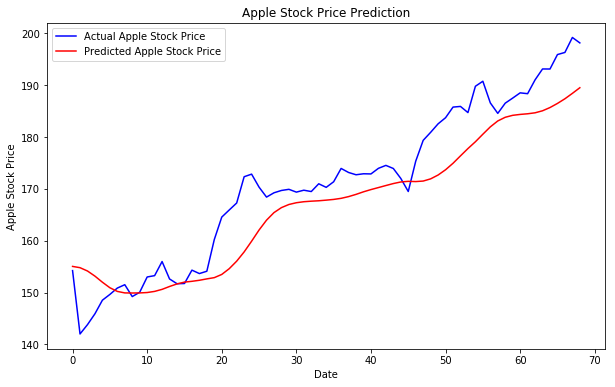

In [62]:
plt.figure(figsize=(10,6))  
plt.plot(test_stock_data_processed, color='blue', label='Actual Apple Stock Price')  
plt.plot(predicted_stock_price , color='red', label='Predicted Apple Stock Price')  
plt.title('Apple Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('Apple Stock Price')  
plt.legend()  
plt.show()  

In [0]:
#inputs = inputs.reshape(-1,1)
#inputs = sc.transform(inputs)


test_inputs = test_stock_data_processed.reshape(-1,1)
test_inputs = sc.transform(test_inputs)


print(test_inputs.shape)

In [0]:
test_features = []
for i in range(60, 291):
    test_features.append(test_inputs[i-60:i, 0])
    
test_features = np.array(test_features)

In [0]:
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))  
print(test_features.shape)

In [0]:
predicted_stock_price = model.predict(test_features)

In [0]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price.shape)

In [0]:
print(test_stock_data_processed.shape)

In [0]:
plt.figure(figsize=(10,6))  
plt.plot(test_stock_data_processed, color='blue', label='Actual Apple Stock Price')  
plt.plot(predicted_stock_price , color='red', label='Predicted Apple Stock Price')  
plt.title('Apple Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('Apple Stock Price')  
plt.legend()  
plt.show()  

## Download the model and the weights

In [0]:
from google.colab import files

In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

In [0]:
files.download("model.json")

In [0]:
model.save('weights.h5')
files.download('weights.h5')